#### Intro

This notebook:
- parses a dump of OKC messages
- compares the vocabularies and word distributions of incoming and outgoing messages
- offers basic search based on tf-idf (e.g. if you search for "entropy" it returns the most relevant messages where that word appears to be important)

Getting started:
- Get your own message dump in just 5 minutes using: https://github.com/lehrblogger/OkCupid-Message-Downloader)

Coming up:
- correlating match percentage and thread length
- analysing features of entire threads with a person

In [153]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import os
import operator
import math

#### Preprocessing

In [2]:
d = open("message_output_file.txt").readlines()
d = [e[:-1] for e in d if e != '\n']

In [3]:
# parsing data into dataframe
df = pd.DataFrame(columns = ['url', 'from', 'to', 'length', 'body'])
for i in range(len(d)):
    key = d[i].split(":",1)[0]
    if key == 'URL':
        df.set_value(i, 'url', d[i].split(':',1)[1])
    elif key == 'From':
        df.set_value(i-1, 'from', d[i].split(':',1)[1])
    elif key == 'To':
        df.set_value(i-2, 'to', d[i].split(':',1)[1])
    elif key == 'Date':
        pass
    elif key == 'Subject':
        pass
    elif key == 'Content-Length':
        df.set_value(i-5, 'length', int(d[i].split(':',1)[1]))
    else:
        df.set_value(i-6, 'body', d[i])

In [4]:
# reindexing
df['id'] = list(range(len(df)))
df.set_index('id', inplace=True)

In [5]:
# when there are multiple messages from the same person, we have nans as the sender
# getting rows that have nans
nan = []
for i in range(len(df)):
    if str(df.url[i]) == "nan":
        nan.append(i)

In [6]:
# a function that returns the index of the parent message
def getParent(n, list):
    parent = n - 1
    if parent not in list:
        return parent
    else:
        return getParent(parent, list)

In [7]:
# updating the body of the parents with the children's messages
for i in nan:
    parent = getParent(i, nan)
    df.set_value(parent, 'body', str(df.body.values[parent]) + " " + str(df.body.values[i]))

In [8]:
# dropping rows with nans, reindexing
df = df.dropna()
df = df.reset_index(drop=True)

In [168]:
df.head()

#### My  and Their messages

In [11]:
#getting indices of rows with my and their messages
mine, theirs= [], []
for i in range(len(df)):
    if df['from'].values[i] == 'your_OKC_username': # in my case there had to be a space before my username
        mine.append(i)
theirs = [i for i in range(len(df)) if i not in mine]
people = df.groupby('from', as_index=True) # the len(people) tells you how many people you talked to

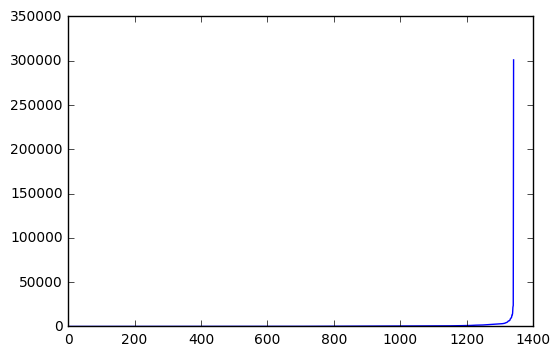

In [12]:
message_numbers = people['length'].sum().values
plt.plot(np.sort(message_numbers))

Message lengths usually have a long tail distribution. Cool!

#### Exploring words and vocabularies

In [13]:
# a function to tokenize, to get rid of Uppercase, to Stem, and to remove stopwords
# feel free to replace hungarian with stopwords in other languages that appear in your messages
def tokenize(text):
    stop = list(set(stopwords.words('english')) | set(list(string.punctuation))  |
                set(stopwords.words('hungarian')))
    for i in ["'s", "'m", "...", '(', "n't", '``', "'re", "'ve", "'i", "''", "'d","'ll", 
          'es', 'na']:
        stop.append(i)
    tokens = nltk.word_tokenize(text)
    lower = [w.lower() for w in tokens]
    stopped = [w for w in lower if w not in stop]
    stemmed = [PorterStemmer().stem(w) for w in stopped]
    return stemmed

In [14]:
# creating Vocabularies
myDf = df.iloc[mine]
myMsg = " ".join([myDf['body'].values[i] for i in range(len(myDf))]) #extracting words from df['body']
mWords = tokenize(myMsg)
mVocab = sorted(set(mWords))

thDf = df.iloc[theirs]
thMsg = " ".join([thDf['body'].values[i] for i in range(len(thDf))])
tWords = tokenize(thMsg)
tVocab = sorted(set(tWords))

In [15]:
len(mVocab), len(tVocab), len(mWords), len(tWords)

(5893, 11612, 27442, 59738)

In [16]:
# average length of mine and theirs
myDf['length'].values.mean(), thDf['length'].values.mean()

(130.10894941634243, 143.97130876186273)

In [17]:
mF = FreqDist(mWords)
tF = FreqDist(tWords)

In [18]:
print(mF.most_common(10))
print(tF.most_common(10))

[('think', 297), ('like', 255), ('realli', 243), ('also', 217), ('day', 173), ('go', 168), ('peopl', 159), ('get', 154), ('know', 153), ('time', 146)]
[('like', 787), ('would', 491), ('think', 427), ('know', 420), ('sorri', 397), ('get', 374), ('go', 359), ('hey', 358), ('longer', 349), ('account', 340)]


In [19]:
# creating lists of messages
myList = [tokenize(myDf['body'].values[i]) for i in range(len(myDf))]
thList = [tokenize(thDf['body'].values[i]) for i in range(len(thDf))]

##  tf-idf

#### use

- a term-weighting scheme
- how important a word is to a document in a corpus
- scoring a document's relevance given a query

#### term frequency

In [155]:
'''term frequency is the number of times a word occures in a document.
term is a string, doc is a list of strings (tokenized)'''
def term_frequency(term, doc):
    return doc.count(term)

'''Augmented frequency prevents bias towards longer documents.
It is the raw frequency divided by the 
maximum raw frequency of any term in the document
(uses double normalization (0.5) as a weighting scheme)
term is a string, doc is a list of strings'''
def augmented_term_frequency(term, doc):
    max_freq = max([term_frequency(token, doc) for token in doc])
    return (0.5 + ((0.5 * term_frequency(term, doc))/max_freq))

#### inverse document frequency

In [156]:
'''the logarithmically scaled inverse fraction of the documents that contain the word.
docs is a list of lists of strings (tokenized)
function returns a dict of tokens and IDFs'''
def inverse_document_frequencies(docs):
    idf_dict = {}
    vocab = set([word for doc in docs for word in doc])
    for word in vocab:
        contains_word = map(lambda doc: word in doc, docs)
        idf_dict[word] = 1 + math.log(len(docs)/(sum(contains_word)))
    return idf_dict

In [158]:
# returns the tf-idf scores for a document in the context of a corpus
# takes a doc that is a list of strings and docs that is a list od docs
# returns a sorted dict where the key is the tf-idf score of the words in the given doc

def tfidf(doc, docs):
    idf = inverse_document_frequencies(docs)
    tf_idf = {}
    for term in idf.keys():
        term_freq = term_frequency(term, doc)
        tf_idf[term] = (term_freq * idf[term])
        tf_idf = dict(filter(lambda x: x[1] > 0, tf_idf.items()))
    return sorted(tf_idf.items(), key=operator.itemgetter(1), reverse=True)

#### ranking function

summing the tf–idf for each query term

In [159]:
# query is a list of strings
def doc_scores(one_word_query, docs):
    docs_scored_words = [tfidf(doc, docs) for doc in docs]
    doc_sc = {}
    for i in range(len(docs_scored_words)):
        doc = docs_scored_words[i]
        doc_score = 0
        for token in doc:
            if token[0] in one_word_query:
                doc_score += token[1]
        doc_sc[i] = doc_score      
    return doc_sc
    
# returns the index of the highest ranking document(s) given a query    
def rank(multiple_word_query, docs, n_of_results):
    query_words =tokenize(multiple_word_query)
    scores = doc_scores(query_words[0], docs)
    if len(query_words) > 1:
        for word in query_words[1:]:
            score_dict = doc_scores(word, docs)
            for k,v in score_dict.items():
                scores[k] += v
    highest_indices = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)[:n_of_results]
    return [highest_indices[i][0] for i in range(len(highest_indices)) if highest_indices[i][1] > 0 ]
    
# returns a list of the highest ranking docs
def search(search_string, docs, n_of_results):
    indices_to_display = rank(search_string, docs, n_of_results)
    return [[docs[i]] for i in indices_to_display]

#### quick testing

In [160]:
test_corpus = [["John", "play", "dull"], 
               ["blue", "warm", "play", "play"], 
               ["playful", "play", "blue", "hard"]] #assumes tokenized
test_query = "play"
test_search_string = "play harder"

In [161]:
doc_scores(test_query, test_corpus)

{0: 1.0, 1: 2.0, 2: 1.0}

In [162]:
rank(test_query, test_corpus, 3)

[1, 0, 2]

In [163]:
rank(test_search_string, test_corpus, 1)

[2]

In [164]:
search(test_search_string, test_corpus, 2)

[[['playful', 'play', 'blue', 'hard']], [['blue', 'warm', 'play', 'play']]]

#### okc search

In [165]:
# try running this on a slice of myList or thList, to make it faster
def okSearch(search_string, corpus, number_of_results):
    if corpus == "out":
        in_result_indices = rank(search_string, myList[:50], number_of_results)
        results_to_display = [(myDf['body'].values[i]) for i in in_result_indices]
        print('Results for "{}" in messsages you sent:\n\n'.format(search_string) + "\n\n".join(results_to_display))
    if corpus == "in":
        in_result_indices = rank(search_string, thList[:50], number_of_results)
        results_to_display = [(thDf['body'].values[i]) for i in in_result_indices]
        print('Results for "{}" in messages you received:\n\n'.format(search_string) + "\n\n".join(results_to_display))

In [166]:
okSearch("feel", "out", 3)

Results for "feel" in messsages you sent:

I feel a really big difference might be depth :) I never actually read anything in the topic, I just find myself thinking about it a lot :)

though actually I had an 8 hour walk with a friend yesterday and then another 11walk with another friend today, so I feel I've been all over the place


In [167]:
okSearch("feel", "in", 3)

Results for "feel" in messages you received:

I feel like so much of what you wrote reminisced with me!

I’d still love to hear what you have to say though! Something that caught my attention from your profile is that you said “and how I feel about it”. In philosophy we analyse lots of arguments in favour or against things like transhumanism or free will, which is quite important, but it’s also very distant. I don’t think we give enough thought to what those things mean to our individual lives! Think of it like this: It’s one thing to discuss the difficulty of telling whether or not certain advanced AI has a consciousness, it’s another very different thing to think about what is like to be confronted with an AI like the one in Ex Machina. :O

But I'm game. Let me know when you're feeling free and rowdy
